In [ ]:
# Native libraries
import shutil
import os
from pathlib import Path
import copy
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union


# Third party libraries
from datetime import datetime
import pandas as pd
import numpy as np
from datasets import load_dataset, Audio, Dataset, load_metric
from sklearn.model_selection import train_test_split
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback
import librosa
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# setup

target_sampling_rate = 16000
model_name = "facebook/wav2vec2-large-960h"

ds_dir = r'common_voice'
ds_csv_dir = r'common_voice/cv-valid-train-q2.csv'

bs = 16
epoch_num = 10
grad_accum_steps = 2


In [ ]:
# import socket
# socket.getaddrinfo('localhost', 8080)

[(<AddressFamily.AF_INET6: 23>, 0, 0, '', ('::1', 8080, 0, 0)),
 (<AddressFamily.AF_INET: 2>, 0, 0, '', ('127.0.0.1', 8080))]

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## split into train and validation dataset

### check distribution of dataset

In [ ]:
ds_dir = r'common_voice/cv-valid-train'
ds_csv_dir = r'common_voice/cv-valid-train.csv'

In [7]:
df = pd.read_csv(ds_csv_dir)

In [8]:
df.head(3)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN


In [ ]:
# length of text to check distribution
df['length_text'] = df['text'].apply(lambda x:len(x))

In [21]:
df.fillna('undefined', inplace=True)

C:\Users\min hua\AppData\Local\Temp\ipykernel_2512\1758817273.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'undefined' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('undefined', inplace=True)


In [25]:
print(df.age.unique())
print(df.gender.unique())
print(df.accent.unique())
print(df.duration.unique())

['undefined' 'twenties' 'seventies' 'thirties' 'sixties' 'fifties'
 'fourties' 'teens' 'eighties']
['undefined' 'female' 'male' 'other']
['undefined' 'us' 'england' 'australia' 'indian' 'canada' 'malaysia'
 'ireland' 'bermuda' 'scotland' 'african' 'newzealand' 'wales'
 'philippines' 'singapore' 'hongkong' 'southatlandtic']
['undefined']


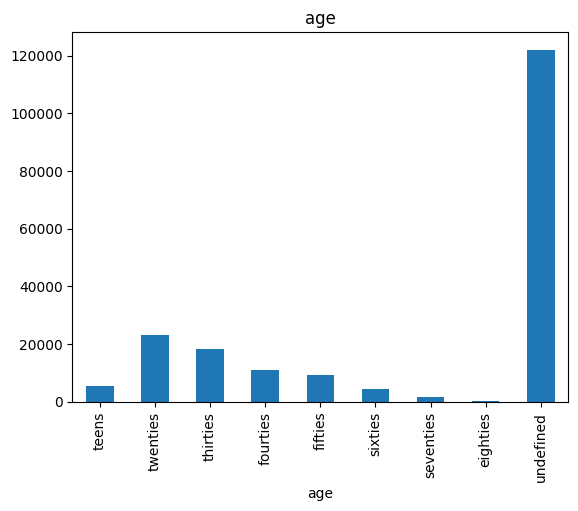

In [27]:
df['age'].value_counts().loc[['teens','twenties','thirties','fourties','fifties','sixties','seventies','eighties', 'undefined']].plot.bar(title='age');

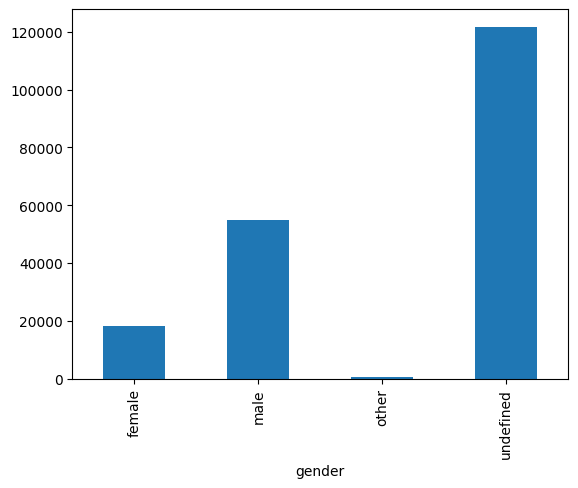

In [32]:
df['gender'].value_counts().loc[['female','male','other','undefined']].plot.bar();

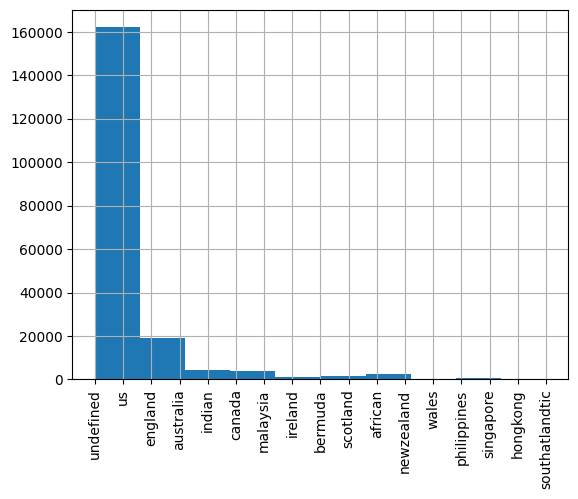

In [31]:
df['accent'].hist(xrot='vertical');

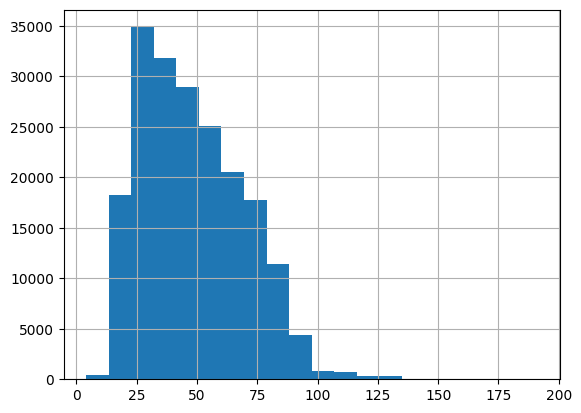

In [37]:
df['length_text'].hist(bins=20);

### stratify splitting based on text length and accent distribution

In [41]:
df['length_text'].quantile(.25),df['length_text'].quantile(.5),df['length_text'].quantile(.75), df['length_text'].max()

(31.0, 45.0, 64.0, 191)

In [46]:
df['length_text_bin'] = pd.cut(df['length_text'], bins=[0, 31.0, 45.0, 64.0, 191], labels=list(range(4)))

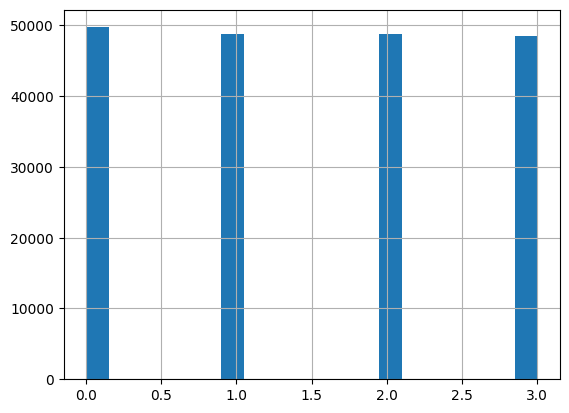

In [47]:
df['length_text_bin'].hist(bins=20);

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df[['filename']], df[['length_text_bin', 'accent', 'gender']], test_size=0.3, random_state=42, stratify=df[['length_text_bin', 'accent']])

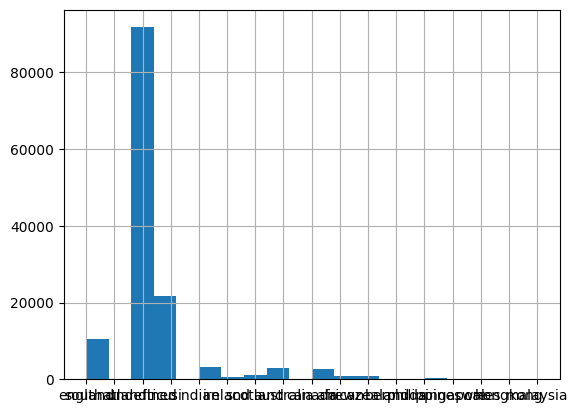

In [59]:
y_train['accent'].hist(bins=20);

In [ ]:
# create new column for cv-valid-train call train_valid so this condition will split into train valid ds

df[['train_valid']] = True
df.loc[X_test['filename'].index, 'train_valid'] = False

In [61]:
df.head(3)

,filename,text,up_votes,down_votes,age,gender,accent,duration,length_text,length_text_bin,train_valid
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,undefined,undefined,undefined,undefined,62,2,True
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,undefined,undefined,undefined,undefined,42,1,True
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,undefined,undefined,undefined,undefined,69,3,True


In [71]:
df.to_csv('common_voice/cv-valid-train-2.csv', index=False)

## preprocessing

In [ ]:
# load processor and model
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(
    model_name,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    ).to(device) # device_map='cuda' doesn't work, logits end up all nan


c:\Users\min hua\miniconda3\envs\pytorch_310_hf\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (i

In [4]:
df = pd.read_csv(ds_csv_dir)
display(df.head(3))

,filename,text,up_votes,down_votes,age,gender,accent,duration,length_text,length_text_bin,train_valid
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,undefined,undefined,undefined,undefined,62,2,True
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,undefined,undefined,undefined,undefined,42,1,True
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,undefined,undefined,undefined,undefined,69,3,False


In [ ]:
# INITIALLY TO USE THIS FOR TRAINING AND VALIDATION DATASET, but can't load the entire training dataset, so attempted to upload to huggingface then load and stream data
train_mask = df['train_valid']==True
train_filename_arr = list(df[train_mask]['filename'])
train_labels_arr = list(df[train_mask]['text'])

valid_mask = df['train_valid']==False
valid_filename_arr = list(df[valid_mask]['filename'])
valid_labels_arr = list(df[valid_mask]['text'])

In [31]:
# copy into separate train and validation folders to upload to huggingface (not enough resources to load locally)
# for train_filename in train_filename_arr:
#     shutil.copy(os.path.join(r'common_voice', train_filename), r'common_voice_train_ds_v1')

# for valid_filename in valid_filename_arr:
#     shutil.copy(os.path.join(r'common_voice', valid_filename), r'common_voice_valid_ds_v1')

# load train and valid datasets from huggingface directly (limited to 10000 files only) but will use this for now
train_ds = load_dataset("gmh98/common_voice_train_ds_v1", split='train', streaming=True)
val_ds = load_dataset("gmh98/common_voice_valid_ds_v1", split='train', streaming=True)


Resolving data files:   0%|          | 0/9900 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/9900 [00:00<?, ?it/s]

In [43]:
def preprocess_batch(batch):
    # Load audio and resample to 16 kHz
    audio = batch["audio"]
    waveform, sampling_rate = audio["array"], audio["sampling_rate"]
    if sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(torch.tensor(waveform, dtype=torch.float32)).numpy()

    # Process audio for model
    input_values = processor(waveform, sampling_rate=target_sampling_rate, return_tensors="pt").input_values[0]

    # Retrieve the label if available
    label = batch.get("text", "")
    labels = processor.tokenizer(label, return_tensors="pt", padding=True).input_ids[0]

    return {"input_values": input_values, "labels": labels}

# Apply the preprocessing to each dataset
train_dataset = train_ds.map(preprocess_batch, remove_columns=["audio"], batched=True)
valid_dataset = val_ds.map(preprocess_batch, remove_columns=["audio"], batched=True)

In [ ]:
def process_audio(sample):
    # Load audio array from the file or array
    if isinstance(sample['audio'], dict):
        # If audio is stored as a dict with 'array' and 'sampling_rate' keys
        audio_array = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']
    else:
        # If audio is stored as a path
        audio_array, sampling_rate = librosa.load(sample['audio'], sr=None)
        
    # Optional: Resample if needed
    target_sr = 16000  # Define your target sampling rate
    if sampling_rate != target_sr:
        audio_array = librosa.resample(
            y=audio_array, 
            orig_sr=sampling_rate, 
            target_sr=target_sr
        )
        sampling_rate = target_sr
        
    return {
        'audio_array': audio_array,
        'sampling_rate': sampling_rate
    }

# Apply the preprocessing to each dataset
train_dataset = train_ds.map(process_audio)
valid_dataset = val_ds.map(process_audio)

## set up Trainer, dataloader, start training

In [60]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator for dynamic padding of input and label sequences for CTC.
    
    Args:
        processor (Wav2Vec2Processor): Processor for handling data.
        padding (bool, str, optional): Padding strategy ('longest', 'max_length', or 'do_not_pad'). Default is True.
        max_len (int, optional): Max length for input padding.
        max_len_labels (int, optional): Max length for label padding.
        pad_to_mult (int, optional): Pad sequence to a multiple (useful for Tensor Cores).
    """
    
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_len: Optional[int] = None
    max_len_labels: Optional[int] = None
    pad_to_mult: Optional[int] = None
    pad_to_mult_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Separate inputs and labels for different padding
        inputs = [{"input_values": f["input_values"]} for f in features]
        labels = [{"input_ids": f["labels"]} for f in features]

        # Pad inputs and labels
        batch = self.processor.pad(
            inputs,
            padding=self.padding,
            max_length=self.max_len,
            pad_to_multiple_of=self.pad_to_mult,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                labels,
                padding=self.padding,
                max_length=self.max_len_labels,
                pad_to_multiple_of=self.pad_to_mult_labels,
                return_tensors="pt",
            )

        # Set padding tokens in labels to -100 for loss calculation
        batch["labels"] = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        return batch

In [51]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
# data_collator = DataCollatorWithPadding(tokenizer=processor.tokenizer, padding=True)

In [52]:
# Load WER metric (use 'cer' if you'd like Character Error Rate)
wer_metric = load_metric("wer", trust_remote_code=True)

# Define a compute_metrics function for evaluation
def compute_metrics(pred):
    # Decode predictions and labels
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    
    # Decode labels (ignoring -100 used for padding)
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)
    
    # Calculate Word Error Rate
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

In [53]:
class LogPredictionsCallback(TrainerCallback):
    """To log the training and validation loss plots, learning rate predicted text after every step/epoch"""
    def __init__(self, processor, eval_dataset, df, log_dir="./logs"):
        self.processor = processor
        self.eval_dataset = eval_dataset
        self.writer = SummaryWriter(log_dir)
        self.df = df
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.current_model = None
        self.step_count = 2
    
    def inference(self, state, valid_filename):
        if self.current_model is None:
            print("Warning: No model available for inference")
            return

        try:

            # Get ground truth
            ground_truth = self.df[self.df['filename']==('cv-valid-train/'+ valid_filename)]['text'].item()
        
            # Load and resample audio
            speech_array, sampling_rate = torchaudio.load(os.path.join(ds_dir, 'cv-valid-train', valid_filename))
            resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
            speech_array = resampler(speech_array)

            # Preprocess the audio
            input_values = self.processor(speech_array.squeeze(), return_tensors="pt", padding="longest").input_values

            # Generate the transcription using the current model
            with torch.no_grad():
                self.current_model.eval()  # Ensure model is in eval mode
                logits = self.current_model(input_values.to(self.device)).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = self.processor.decode(predicted_ids[0])

            # Print out confirmation
            print(f"Logged example at step {state.global_step}")
            print(f"Ground Truth: {ground_truth}")
            print(f"Prediction: {transcription}")

            # Log to TensorBoard
            self.writer.add_text(
                f"Ground Truth {valid_filename}",
                f"{ground_truth}",
                self.step_count
            )
            self.writer.add_text(
                f"Prediction {valid_filename}",
                f"{transcription}",
                self.step_count
            )
            self.writer.flush()

        except Exception as e:
            print(f"Error during inference for file {valid_filename}: {str(e)}")

    def on_step_end(self, args, state, control, model=None, **kwargs):
        """Update the model reference after each step"""
        if model is not None:
            self.current_model = model

    def on_evaluate(self, args, state, control, model=None, **kwargs):
        """Run inference on evaluation dataset"""
        if model is not None:
            self.current_model = model
            
        valid_filename_arr = ["sample-005662.mp3", "sample-046328.mp3", "sample-082473.mp3"]
        
        for valid_filename in valid_filename_arr:
            self.inference(state, valid_filename)

        self.step_count += 2

    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        """Update the model reference after each epoch"""
        if model is not None:
            self.current_model = model

    def on_train_end(self, args, state, control, **kwargs):
        self.writer.close()

In [71]:
# calculate maximum number of steps (9900 is training samples)
max_steps = (9900 // bs) * epoch_num // grad_accum_steps

# Define training arguments
training_args = TrainingArguments(
    output_dir="./wav2vec2-large-960h-cv",
    num_train_epochs=epoch_num,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    gradient_accumulation_steps=grad_accum_steps,
    max_steps=max_steps,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    logging_steps=300, # logging frequency
    save_steps=300,
    eval_steps=300,
    learning_rate=1e-4,
    weight_decay=0.005,
    warmup_steps=0,
    save_total_limit=2,
    fp16=True,
    logging_dir='./logs', # tensorboard logging directory
    push_to_hub=False
)

# callback to log train and validation loss plot, learning rate, and predicted text
callback = LogPredictionsCallback(
    processor=processor,
    eval_dataset=valid_dataset,
    df=df,
    log_dir="./logs"
)

# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'], # train_dataset
    eval_dataset=datasets['validation'],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

# Start training
trainer.train()

c:\Users\min hua\miniconda3\envs\pytorch_310_hf\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\min hua\miniconda3\envs\pytorch_310_hf\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/3090 [00:00<?, ?it/s]

c:\Users\min hua\miniconda3\envs\pytorch_310_hf\lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
c:\Users\min hua\miniconda3\envs\pytorch_310_hf\lib\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:862: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 20.89 GiB is allocated by PyTorch, and 744.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)